In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize
import uuid #to generate random id
import pickle #to save/load list of selected hens
import cv2

#test equal variance
from scipy.stats import levene

#clustering
from sklearn.cluster import AgglomerativeClustering 

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#interpolate curves for clustering among birds with not exact same days tracked
#from scipy.interpolate import interp1d

#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, cohen_kappa_score, r2_score,\
mean_squared_error, mean_absolute_error, explained_variance_score#catboost, for a better support of categorical data
from catboost import CatBoostClassifier, Pool
from scipy.stats import pearsonr, spearmanr 
import scipy.stats as stats

#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well

#plot
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp #for barplot
from mpl_toolkits.mplot3d import Axes3D

#network
import networkx as nx

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import chi2_distance, ts_visual, time_series_henColumn_tsRow, correct_key, FB_daily, FB_process_hen
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_dataoutput = config.path_dataoutput
path_initial_data = config.path_initial_data
id_run = config.id_run
#id_run = 'chapter0_final_'
#path_dataoutput = r'G:\VPHI\Welfare\2- Research Projects\OFHE2.OriginsE2\DataOutput'
#path_extracted_data = os.path.join(path_dataoutput,'TrackingSystem') 
#path_extracted_data = os.path.join(path_extracted_data, id_run)
dico_night_hour = config.dico_night_hour
dico_matching = config.dico_matching
li_binmn = config.li_binmn
penalty = config.penalty
dico_HAID_date = config.dico_HAID_date
dico_window = config.dico_window
path_extracted_HA = config.path_extracted_HA
path_extracted_HA_visual = config.path_extracted_HA_visual
path_extracted_data_SNA = config.path_extracted_data_SNA
#create a director if not existing
if not os.path.exists(path_extracted_HA_visual):
    os.makedirs(path_extracted_HA_visual)
print(id_run)

change the configuration file if not done yet!
ALLDATA_


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [4]:
#focal birds info (one row per bird) for weight
df_FB = FB_process_hen(config) 
#df_FB['percentage_of_gain_weight'] = df_FB.apply(lambda x: (x['weight 23-11-2020']-x['29-09 weight'])/x['29-09 weight']*100, axis=1)
dico_cl_name = {'EPI': 'Other', 'NewAfterEpiLOST':'Other','MEXP':'MEXP', 'LEXP': 'LEXP', 'LEXPLOST':'Other','MEXPLOST':'Other','NewAfterEpi':'Other'}
df_FB['CLASS'] = df_FB['CLASS'].map(lambda x: dico_cl_name[x])
print(df_FB.shape)
df_FB.head(3)

(232, 14)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,early_death,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment
0,hen_1,pen9,Other,1.0,2020-06-10,0.0,1134.0,57.0,1696.5,1787.8,1800.9,NaN,NaN,OFH
1,hen_10,pen11,LEXP,1.0,2020-06-10,0.0,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,1713.4,OFH
2,hen_100,pen5,Other,3.0,2020-06-10,0.0,1182.0,80.5,1642.5,NaN,NaN,NaN,NaN,OFH


In [5]:
#HA - feather & leg injuries/podo/bumble
#search in any folder and creat a list of img paths
#os.walk: Python method walk() generates the file names in a directory tree by walking the tree top-down or bottom-up
#to avoid saving images several times, we will do it specifically for images in the KBF folder:
li_df = []
for path_ in glob.glob(os.path.join(path_dataoutput, 'HA', 'HA*', 'HA*.csv')):
    HAID = path_.split('\\')[-1].split('.')[0]
    #if utf8 decode issue: remvoe accent et ^ dans les commentaires :)
    print('---------------------', HAID)
    df_ = pd.read_csv(path_, sep=';') 
    df_['HAID'] = HAID
    df_['date'] = dico_HAID_date[HAID]
    df_ = df_.rename(columns={'Pen ':'Pen'})
    df_ = df_[~df_['FocalLegringName'].isnull()]
    #remove students non-homogenous anotations
    df_['FocalLegringName'] = df_['FocalLegringName'].map(lambda x: x.replace(' ','').strip())
    print(df_.shape)
    #print(df_.columns)
    #display(df_.head(2))
    li_df.append(df_)
df_HA = pd.concat(li_df)
#small typo corrections
df_HA['BirdType'] = df_HA['BirdType'].fillna('normal')
df_HA['BirdType'] = df_HA['BirdType'].map(lambda x: x.strip(' '))
#we add a non-focal columns due to the KBF csv that does not have bird type
df_HA['IsNonFocal'] = df_HA['BirdType'].map(lambda x: x=='NF')
df_HA = df_HA.rename(columns={'Pen':'PenID'})
df_HA['PenID'] = df_HA['PenID'].map(lambda x: 'pen'+str(int(x)))
print(df_HA.columns)
print(df_HA.shape)
df_HA.head(3)

--------------------- HA1


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,3,4,6,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(256, 20)
--------------------- HA2
(256, 30)
--------------------- HA3


C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,3,6,15,16,17,26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(260, 30)
--------------------- HA4


C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,3,6,15,16,17,18,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(273, 30)
--------------------- HA5


C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,2,4,5,8,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(301, 31)
Index(['Person_toe', 'Time', 'PenID', 'FocalLegringName', 'BirdType',
       'CombPecks', 'Toes', 'RFPododermatitis', 'RFBumblefoot', 'RFinjuries',
       'LFPododermatitis', 'LFBumblefoot', 'LFinjuries', 'Reliability_MC',
       'PassageID_toe', 'Diarrhea', 'Commentaires', 'SomeHenID', 'HAID',
       'date', 'Claw', 'Person_feather', 'Reliability_SS', 'PassageID_feather',
       'NeckFeather', 'BreastFeather', 'CloacaFeather', 'BackFeather',
       'WingFeather', 'TailFeather', 'PenMatching', 'IsNonFocal'],
      dtype='object')
(1346, 32)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,Reliability_SS,PassageID_feather,NeckFeather,BreastFeather,CloacaFeather,BackFeather,WingFeather,TailFeather,PenMatching,IsNonFocal
0,M,16:15,pen3,1green,normal,0.0,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,M,13:59,pen5,10green,epi,0.0,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,M,16:14,pen3,11grey,normal,88.0,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [6]:
df_HA['BirdType'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


normal     1183
epi          67
epi new      49
NF           47
Name: BirdType, dtype: int64

In [7]:
#KBF
df_KBF = pd.read_csv(os.path.join(path_extracted_HA, 'KBF_ALL_RECORDS.csv'), sep=';', engine='python') 
df_KBF = df_KBF[~df_KBF['BirdID'].isnull()]
df_KBF['Info'] = df_KBF['BirdID'].map(lambda x: re.split('(\d+)',x.strip(' ')))
df_KBF['PenID'] = df_KBF['Info'].map(lambda x: 'pen'+str(int(x[3])))
df_KBF['FocalLegringName'] = df_KBF['Info'].map(lambda x: str(int(x[1]))+str(x[2]))
df_KBF['backpack'] = df_KBF['Info'].map(lambda x: x[-1] if not x[-1].isnumeric() else '')
#add non focal birds:
#TO VERIFY: OK
#df_KBF[(df_KBF['HAID']=='HA5')&(df_KBF['backpack']=='')].groupby(['PenID']).count() #shoud be 6 non focal per pen
df_KBF['IsNonFocal'] = False
df_KBF.loc[(df_KBF['HAID']=='HA5')&(df_KBF['backpack']==''),'IsNonFocal'] = True
display(df_KBF['IsNonFocal'].value_counts())
df_KBF_NF = df_KBF[df_KBF['IsNonFocal']].copy()
df_KBF = df_KBF[~df_KBF['IsNonFocal']].copy()
print(df_KBF.shape)
df_KBF.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:4: DeprecationWarning: invalid escape sequence \d
<>:4: DeprecationWarning: invalid escape sequence \d
<ipython-input-7-7ee76e5de6fe>:4: DeprecationWarning: invalid escape sequence \d
  df_KBF['Info'] = df_KBF['BirdID'].map(lambda x: re.split('(\d+)',x.strip(' ')))


False    846
True      48
Name: IsNonFocal, dtype: int64

(846, 15)


,initial_path_img,actual_path_img,imageID,HAID,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Unnamed: 9,Info,PenID,FocalLegringName,backpack,IsNonFocal
0,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,0.0,HA4,294.0,20,0.0,57green5pp,NaN,NaN,"[, 57, green, 5, pp]",pen5,57green,pp,False
1,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,1.0,HA4,461.0,18,0.0,56orange12sg,NaN,NaN,"[, 56, orange, 12, sg]",pen12,56orange,sg,False
2,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,2.0,HA3,78.0,0,0.0,29black8wp,NaN,NaN,"[, 29, black, 8, wp]",pen8,29black,wp,False


# Preprocessing

In [8]:
df_HA.columns

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Person_toe', 'Time', 'PenID', 'FocalLegringName', 'BirdType',
       'CombPecks', 'Toes', 'RFPododermatitis', 'RFBumblefoot', 'RFinjuries',
       'LFPododermatitis', 'LFBumblefoot', 'LFinjuries', 'Reliability_MC',
       'PassageID_toe', 'Diarrhea', 'Commentaires', 'SomeHenID', 'HAID',
       'date', 'Claw', 'Person_feather', 'Reliability_SS', 'PassageID_feather',
       'NeckFeather', 'BreastFeather', 'CloacaFeather', 'BackFeather',
       'WingFeather', 'TailFeather', 'PenMatching', 'IsNonFocal'],
      dtype='object')

In [9]:
#compeck: HA1: as worse time for this
#overall pododeratitis: should be worst over time, so only HA4
df_HA['Injuries'] = df_HA.apply(lambda x: x['LFinjuries']+x['RFinjuries'], axis=1)
df_HA['Pododermatitis'] = df_HA.apply(lambda x: x['RFPododermatitis']+x['LFPododermatitis'], axis=1)
df_HA['Pododermatitis_atleastonehigher100'] = df_HA.apply(lambda x: int((x['RFPododermatitis']>100) | (x['LFPododermatitis']>100)), axis=1)
df_HA['Bumblefoot'] = df_HA.apply(lambda x: x['LFBumblefoot']+x['RFBumblefoot'], axis=1)
df_HA['HasBumblefoot'] = df_HA.apply(lambda x: max(x['LFBumblefoot'],x['RFBumblefoot'])>0, axis=1)
df_HA['Toes'] = df_HA['Toes'].fillna('')
df_HA['Toes_inflammed'] = df_HA['Toes'].map(lambda x: 'inflammed' in x.lower())
#df_HA['BigInjuriesOrInflammed'] = df_HA.apply(lambda x: 1 if ((x['LFinjuries']>=100) | (x['RFinjuries']>=100) |\
#                                                              (x['Toes_inflammed']==1)) else 0, axis=1)
#keep one general leg health status: higher versus none
df_HA['GeneralToe'] = df_HA.apply(lambda x: (max(x['LFinjuries'], x['RFinjuries'], x['RFPododermatitis'], 
                                                x['LFPododermatitis'])>=100) | 
                                                (x['HasBumblefoot']), axis=1)
display(df_HA['GeneralToe'].value_counts())

#clean diarrhea
df_HA['Diarrhea'] = df_HA['Diarrhea'].replace('N/A',np.nan).replace('N/A ',np.nan)
df_HA['Diarrhea'] = df_HA['Diarrhea'].astype(float)
df_HA['Diarrhea'] = df_HA['Diarrhea'].map(lambda x: 1 if x==2 else x)
#overall feather as in general have the same tendency: only from HA4: as should be worse over time
#keeping the ar with inter and intra higher than 0.7
df_HA['Feathers'] = df_HA.apply(lambda x: np.mean([x['BreastFeather'],x['TailFeather'],x['NeckFeather']]), axis=1)
display(df_HA[df_HA['Feathers'].isnull()].shape)
display(df_HA[~df_HA['Feathers'].isnull()].shape)
df_HA.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False    1190
True      156
Name: GeneralToe, dtype: int64

(267, 40)

(1079, 40)

,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,PenMatching,IsNonFocal,Injuries,Pododermatitis,Pododermatitis_atleastonehigher100,Bumblefoot,HasBumblefoot,Toes_inflammed,GeneralToe,Feathers
0,M,16:15,pen3,1green,normal,0.0,,0.0,0.0,0.0,...,NaN,False,0.0,0.0,0,0.0,False,False,False,NaN
1,M,13:59,pen5,10green,epi,0.0,,0.0,0.0,0.0,...,NaN,False,0.0,0.0,0,0.0,False,False,False,NaN
2,M,16:14,pen3,11grey,normal,88.0,,0.0,0.0,0.0,...,NaN,False,0.0,0.0,0,0.0,False,False,False,NaN


# Add HenID to focal birds, keep non-focal in a separate df

In [10]:
######## create one dataframe with all HA and with HenID!
#first, we remove Non focal birds as they do not have a henID
df_HA_NF = df_HA[df_HA['IsNonFocal']].copy()
df_HA = df_HA[~df_HA['IsNonFocal']].copy()

#open info
df_FB_daily = FB_daily(config)
print(df_FB_daily.shape)
display(df_FB_daily[['date','FocalLegringName','PenID','HenID']].head(3))
df_FB_daily['date'].iloc[0]

#remove typos
for v in ['FocalLegringName','PenID']:
    df_HA[v] = df_HA[v].map(lambda x: x.strip(' '))
    df_FB_daily[v] = df_FB_daily[v].map(lambda x: x.strip(' '))

#add HenID
#as epi and epi_new are exchanged during HA; we should take the date before/ respec. after HA to match. 
#to avoid any confusion we enter them by hand (in column SomeHenID). Same for new legrings!
df_HA_HenID = pd.merge(df_HA, df_FB_daily[['date','FocalLegringName','PenID','HenID']], 
                  on=['date','FocalLegringName','PenID'], how='left') 
print(df_HA.shape, df_FB_daily.shape, df_HA_HenID.shape)
#add the manually the anotated HenID (to avoid mistakes, in the case we would change legring or have two 
#birds from same pen with same legringID (different tagID), Then we would simply annotated manually the HenID when entering 
#the HA observations)
df_HA_HenID['HenID'] = np.where(~df_HA_HenID['SomeHenID'].isnull(), df_HA_HenID['SomeHenID'], df_HA_HenID['HenID']) 

#small verification
#display(df_HA_HenID[~df_HA_HenID['SomeHenID'].isnull()][['SomeHenID','HenID']])
###small verification
#print(df_HA_HenID[df_HA_HenID['HenID'].isnull()][['date','HAID','PenID','HenID','FocalLegringName']].shape)
#df_ = df_HA_HenID[df_HA_HenID['HenID'].isnull()][['date','HAID','PenID','HenID','FocalLegringName']].groupby(['date','HAID','PenID'])['FocalLegringName'].agg(lambda x: set(x)).reset_index()
#df_['nbr_NA_legringID'] = df_['FocalLegringName'].map(lambda x: len(x))
#bird 35 black on HA1 pen 8 was excluded due to missfucntioning tag: this it doe snot match any henid, but thats normal
#print('HERE IS THE OBSERVAION DURING HA THAT DO NOT MATCH ANY HENID:')
#display(df_)
df_test = df_HA_HenID[(df_HA_HenID['HenID'].isnull())&(df_HA_HenID['BirdType']!='NF')][['HAID','PenID','FocalLegringName','BirdType','CombPecks','NeckFeather']]
if df_test.shape[0]>0:
    print('ERROR: some henID are empty:')
    display(df_test)
    sys.exit()
    
#remove small typos
#for now we replace nan with the one we will select, and then we select randomly
df_HA_HenID['Person_toe'] = df_HA_HenID['Person_toe'].fillna('C')
df_HA_HenID['Person_feather'] = df_HA_HenID['Person_feather'].fillna('Sabine')
df_HA_HenID['Person_toe'] = df_HA_HenID['Person_toe'].map(lambda x: x.strip(' '))
df_HA_HenID['Person_feather'] = df_HA_HenID['Person_feather'].map(lambda x: x.strip(' '))
print(df_HA_HenID.shape)
df_HA_HenID.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


From the focalBirdinfo, you have 155 ative tags
(47205, 32)


,date,FocalLegringName,PenID,HenID
0,2020-09-29,3grey,pen9,hen_1
1,2020-09-30,3grey,pen9,hen_1
2,2020-10-01,3grey,pen9,hen_1


(1299, 40) (47205, 32) (1299, 41)
(1299, 41)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,IsNonFocal,Injuries,Pododermatitis,Pododermatitis_atleastonehigher100,Bumblefoot,HasBumblefoot,Toes_inflammed,GeneralToe,Feathers,HenID
0,M,16:15,pen3,1green,normal,0.0,,0.0,0.0,0.0,...,False,0.0,0.0,0,0.0,False,False,False,NaN,hen_81
1,M,13:59,pen5,10green,epi,0.0,,0.0,0.0,0.0,...,False,0.0,0.0,0,0.0,False,False,False,NaN,hen_88
2,M,16:14,pen3,11grey,normal,88.0,,0.0,0.0,0.0,...,False,0.0,0.0,0,0.0,False,False,False,NaN,hen_4


In [11]:
#remove hen_234 as No tracking data
print(df_HA_HenID.shape)
df_HA_HenID = df_HA_HenID[df_HA_HenID['HenID']!='hen_234']
print(df_HA_HenID.shape)

(1299, 41)
(1297, 41)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Select one observation per bird (i.e. for reability birds)

In [12]:
#keep reability birds in a separate df
df_rea = df_HA_HenID[(df_HA_HenID['Reliability_SS']==1)|(df_HA_HenID['Reliability_MC']==1)].copy()
df_rea.to_csv(os.path.join(path_extracted_data,'df_REA.csv'), index=False, sep=';')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
#keep when its a reliability-type-bird only Sabine (as Sabine learned to Satar) THEN take randomly among several remaining obs.
#ATTENTION when reliability =1: we should have at least two people rating it!
#ATTENTION: assuming that reability is in both group in same time!! (which is the case :))
df_HA_HenID['toremove'] = df_HA_HenID.apply(lambda x: (x['Reliability_SS']==1)&(x['Person_feather']=='Satar'), axis=1)
print(df_HA_HenID.shape)
df_HA_HenID = df_HA_HenID[~df_HA_HenID['toremove']]
print(df_HA_HenID.shape)
#remove random observation if there is two from reliability
random.seed(0) #replicable way
df_HA_HenID = shuffle(df_HA_HenID)
df_HA_HenID.drop_duplicates(subset=['HenID','HAID'], keep='first', inplace=True)
#merge all HA from reliability using a random obs for now (then most reliable, once we know and once we have all the name)
df_ = df_HA_HenID.groupby(['HenID','HAID'])['Person_toe','Person_feather'].agg(lambda x: list(x)).reset_index()
df_['nbr_raters'] = df_['Person_feather'].map(lambda x: len(x))
if df_[df_['nbr_raters']>1].shape[0]>0:
    print('ERROR, we still have several observation for a/some (HenID,HAID)')
    sys.exit()
print(df_HA_HenID.shape)
df_HA_HenID.head(3)

(1297, 42)
(1061, 42)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-13-3851750662c4>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_ = df_HA_HenID.groupby(['HenID','HAID'])['Person_toe','Person_feather'].agg(lambda x: list(x)).reset_index()


(844, 42)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,Injuries,Pododermatitis,Pododermatitis_atleastonehigher100,Bumblefoot,HasBumblefoot,Toes_inflammed,GeneralToe,Feathers,HenID,toremove
130,M,09:30,pen9,42grey,normal,25.0,,0.0,0.0,0.0,...,0.0,0.0,0,0.0,False,False,False,NaN,hen_164,False
721,Mark,14:54,pen9,66grey,normal,0.0,,50.0,0.0,0.0,...,0.0,150.0,0,0.0,False,False,True,86.0,hen_181,False
581,Camille,10:30,pen5,2green,normal,130.0,,25.0,0.0,0.0,...,0.0,75.0,0,0.0,False,False,False,92.0,hen_82,False


In [14]:
#display(df_HA_HenID[(df_HA_HenID['PenID']=='pen11')&(df_HA_HenID['HAID']=='HA4')&(df_HA_HenID['FocalLegringName']=='28green')][['HAID','Person_feather','Person_toe','Reliability_MC','Reliability_SS']])

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
#nbr of HA per hen
#df_HA_HenID.groupby('HenID')['HAID'].count().reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Add weight to HA

In [16]:
#add weight to (HenID,HAID)
dico_HAID_h_weight = {}
dico_HAID_h_weight['HA1'] = dict(zip(df_FB['HenID'].tolist(), df_FB['weight 23-11-2020'].tolist()))
dico_HAID_h_weight['HA2'] = dict(zip(df_FB['HenID'].tolist(), df_FB['weight 04-01-2021'].tolist()))
dico_HAID_h_weight['HA3'] = dict(zip(df_FB['HenID'].tolist(), df_FB['weight 01-02-21'].tolist()))
dico_HAID_h_weight['HA4'] = dict(zip(df_FB['HenID'].tolist(), df_FB['weight 12-04-21'].tolist()))
dico_HAID_h_weight['HA5'] = dict(zip(df_FB['HenID'].tolist(), df_FB['weight 26-07-21'].tolist()))
df_HA_HenID['weight'] = df_HA_HenID.apply(lambda x: dico_HAID_h_weight[x['HAID']].get(x['HenID'],np.nan), axis=1)
print('Note that if a hen is in df_HA_HenID, it also should have the weight, look at exception:')
#pen 12 HA for one HA is normal as the student entered data incorrectly
display(df_HA_HenID[df_HA_HenID['weight'].isnull()])
df_HA_HenID.head(3)

Note that if a hen is in df_HA_HenID, it also should have the weight, look at exception:


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,Pododermatitis,Pododermatitis_atleastonehigher100,Bumblefoot,HasBumblefoot,Toes_inflammed,GeneralToe,Feathers,HenID,toremove,weight
272,C,08:58,pen12,32orange,normal,25.0,,0.0,0.0,0.0,...,0.0,0,0.0,False,False,False,88.333333,hen_61,False,NaN
403,M,08:58,pen12,42orange,normal,25.0,,50.0,0.0,0.0,...,150.0,0,0.0,False,False,True,98.666667,hen_71,False,NaN
282,C,08:58,pen12,51orange,normal,25.0,R inflammed,100.0,0.0,0.0,...,150.0,0,0.0,False,True,True,100.000000,hen_76,False,NaN
275,C,08:58,pen12,21black,normal,25.0,,0.0,0.0,0.0,...,0.0,0,0.0,False,False,False,97.000000,hen_133,False,NaN
402,M,08:58,pen12,39orange,normal,0.0,,50.0,0.0,0.0,...,50.0,0,0.0,False,False,False,99.333333,hen_68,False,NaN
395,M,08:58,pen12,27black,normal,0.0,R inflammed,0.0,0.0,0.0,...,50.0,0,0.0,False,True,False,100.000000,hen_137,False,NaN
273,C,08:58,pen12,53black,normal,25.0,,50.0,0.0,0.0,...,100.0,0,0.0,False,False,False,80.333333,hen_155,False,NaN
285,C,08:58,pen12,75black,normal,125.0,,0.0,0.0,0.0,...,0.0,0,0.0,False,False,False,100.000000,hen_122,False,NaN
278,C,08:58,pen12,58black,normal,0.0,,0.0,0.0,0.0,...,0.0,0,0.0,False,False,False,100.000000,hen_159,False,NaN
277,C,08:58,pen12,24orange,normal,65.0,,50.0,0.0,0.0,...,100.0,0,0.0,False,False,False,100.000000,hen_199,False,NaN


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,Pododermatitis,Pododermatitis_atleastonehigher100,Bumblefoot,HasBumblefoot,Toes_inflammed,GeneralToe,Feathers,HenID,toremove,weight
130,M,09:30,pen9,42grey,normal,25.0,,0.0,0.0,0.0,...,0.0,0,0.0,False,False,False,NaN,hen_164,False,1673.8
721,Mark,14:54,pen9,66grey,normal,0.0,,50.0,0.0,0.0,...,150.0,0,0.0,False,False,True,86.0,hen_181,False,2206.9
581,Camille,10:30,pen5,2green,normal,130.0,,25.0,0.0,0.0,...,75.0,0,0.0,False,False,False,92.0,hen_82,False,1790.9


In [17]:
#add WOA and DOA
df_HA_HenID['DOA'] = df_HA_HenID['date'].map(lambda x: (x-dt.datetime(2020,6,3)).days)
df_HA_HenID['WOA'] = df_HA_HenID['DOA'].map(lambda x: math.ceil(x/7))
df_HA_HenID['WOA'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


45    176
35    176
25    175
31    160
60    157
Name: WOA, dtype: int64

In [18]:
#add treatment and class
df_ = df_FB.groupby(['HenID'])[['Treatment', 'CLASS']].agg(lambda x: set(x)).reset_index()
df_['Treatment'] = df_['Treatment'].map(lambda x: list(x)[0] if len(x)==1 else 'error')
df_['CLASS'] = df_['CLASS'].map(lambda x: list(x)[0] if len(x)==1 else 'error')
df_[(df_['CLASS']=='error')|(df_['Treatment']=='error')]
print(df_HA_HenID.shape)
df_HA_HenID = pd.merge(df_HA_HenID, df_, on='HenID', how='left')
print(df_HA_HenID.shape)
df_HA_HenID.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(844, 45)
(844, 47)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,Toes_inflammed,GeneralToe,Feathers,HenID,toremove,weight,DOA,WOA,Treatment,CLASS
0,M,09:30,pen9,42grey,normal,25.0,,0.0,0.0,0.0,...,False,False,NaN,hen_164,False,1673.8,173,25,OFH,Other
1,Mark,14:54,pen9,66grey,normal,0.0,,50.0,0.0,0.0,...,False,True,86.0,hen_181,False,2206.9,243,35,OFH,Other
2,Camille,10:30,pen5,2green,normal,130.0,,25.0,0.0,0.0,...,False,False,92.0,hen_82,False,1790.9,243,35,OFH,Other


# Add KBF ratings

In [19]:
#not on backpack, unnecessary and not that reliable as the tape went away quite often
df_HA_KBF = pd.merge(df_HA_HenID, df_KBF, on=['HAID','PenID','FocalLegringName','IsNonFocal'], how='outer')
print(df_HA_HenID.shape, df_KBF.shape, df_HA_KBF.shape)

(844, 47) (846, 15) (846, 58)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
#TO VERIFY: Look at when KBF data is empty but HA exists
df_HA_KBF[df_HA_KBF['severity'].isnull()].groupby(['HAID','PenID'])[['FocalLegringName']].agg(lambda x: set(x)).reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index


In [21]:
#df_HA[(df_HA['HAID']=='HA5')&(df_HA['FocalLegringName']=='75black')][['SomeHenID']]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
#TO VERIFY: Look at when HA data is empty but KBF exists
#35black from pen 8 in HA1 is removed so its normal (as tag disfunctioning during that time)
#59 orange pen 12 HA5 is normal as NO tracking data at all so useless
df_HA_KBF[(df_HA_KBF['HenID'].isnull())&(df_HA_KBF['IsNonFocal']==False)].groupby(['HAID','PenID'])['FocalLegringName'].agg(lambda x: set(x)).reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HAID,PenID,FocalLegringName
0,HA1,pen8,{35black}
1,HA5,pen12,{59orange}


# Visual

In [23]:
#df_HA[df_HA['Diarrhea']=='0,25'][['HAID','FocalLegringName']]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
#df_HA_KBF[df_HA_KBF['Pododermatitis_atleastonehigher100']==1][['Pododermatitis_atleastonehigher100','RFPododermatitis','LFPododermatitis']]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
#save
df_HA_KBF.to_csv(os.path.join(path_extracted_data,'df_all_HA.csv'), index=False, sep=';')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
#do visual of HenID KBF over time
df_plot = df_HA_KBF.sort_values('HAID').copy()
df_plot = df_plot[~df_plot['actual_path_img'].isnull()] #missing KBF
df_plot = df_plot.groupby(['HenID'])[['HAID','actual_path_img','severity','has_gap']].agg(lambda x: list(x)).reset_index()
for i in tqdm.tqdm(range(df_plot.shape[0])):
    x = df_plot.iloc[i]
    li_path = x['actual_path_img']
    li_HAID = x['HAID']
    henid = x['HenID']
    li_sev = x['severity']
    li_gap = x['has_gap']
    c = len(li_path) ; l = 1
    fig = plt.figure(figsize=(c*3, l*3)) #/100 si trop grand nbr
    for i,path_ in enumerate(li_path):
        plt.subplot(l,c,i+1)
        plt.tight_layout() #avoid titles superpositions
        img = cv2.imread(path_)
        plt.imshow(img)
        plt.xticks([]) #remove xlabel annotations
        plt.yticks([])
        plt.title(li_HAID[i]+' sev:'+str(li_sev[i])+' gap:'+str(li_gap[i]), size=9)
    plt.savefig(os.path.join(path_extracted_HA_visual,'KBF_'+henid+'.png'),dpi=300,format='png',bbox_inches='tight')
    plt.close() #otherwise it will print all plot

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [05:26<00:00,  1.55s/it]


# Focal - Visual

In [27]:
df_HA_HenID.columns

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Person_toe', 'Time', 'PenID', 'FocalLegringName', 'BirdType',
       'CombPecks', 'Toes', 'RFPododermatitis', 'RFBumblefoot', 'RFinjuries',
       'LFPododermatitis', 'LFBumblefoot', 'LFinjuries', 'Reliability_MC',
       'PassageID_toe', 'Diarrhea', 'Commentaires', 'SomeHenID', 'HAID',
       'date', 'Claw', 'Person_feather', 'Reliability_SS', 'PassageID_feather',
       'NeckFeather', 'BreastFeather', 'CloacaFeather', 'BackFeather',
       'WingFeather', 'TailFeather', 'PenMatching', 'IsNonFocal', 'Injuries',
       'Pododermatitis', 'Pododermatitis_atleastonehigher100', 'Bumblefoot',
       'HasBumblefoot', 'Toes_inflammed', 'GeneralToe', 'Feathers', 'HenID',
       'toremove', 'weight', 'DOA', 'WOA', 'Treatment', 'CLASS'],
      dtype='object')

In [28]:
df_HA_HenID['Diarrhea'].unique()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([nan,  1.,  0.])

In [29]:
li_HAvar = ['Pododermatitis', 'Injuries','Feathers','Bumblefoot','HasBumblefoot',
            'CombPecks','NeckFeather','BreastFeather', 'CloacaFeather', 'BackFeather', 'WingFeather','TailFeather','weight',
            'severity'] #Diarrhea
#df_HA_HenID[['HenID','date']+li_HAvar].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
df_HA_HenID['Toes'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                      656
0                     154
L inflammed            12
R inflammed            11
L missing               4
R missing               2
miming                  1
L inflammed (feet)      1
camb blande ?           1
injuries                1
inj.sec                 1
Name: Toes, dtype: int64

In [31]:
df_HA_HenID['Claw'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0                151
L missing          8
R missing          6
1                  5
missing L          2
missing            2
1 old missing      1
L old              1
L old d            1
griffe             1
R claw old         1
missing R          1
R old              1
Name: Claw, dtype: int64

In [32]:
df_HA_KBF['IsNonFocal'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False    846
Name: IsNonFocal, dtype: int64

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


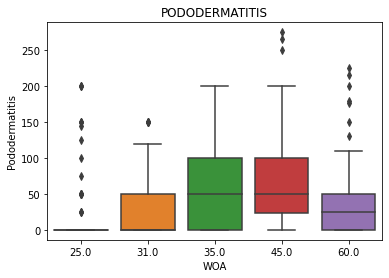

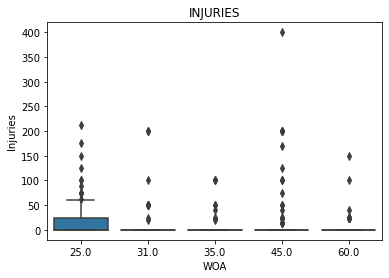

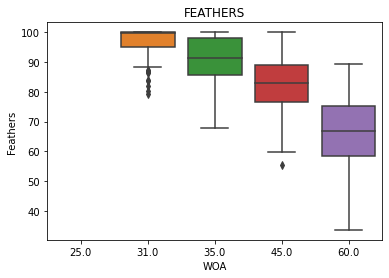

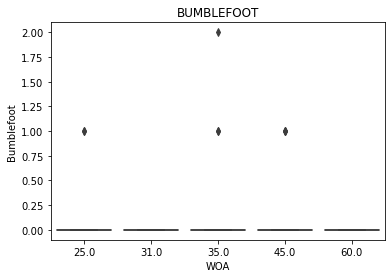

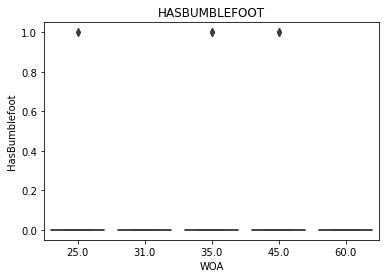

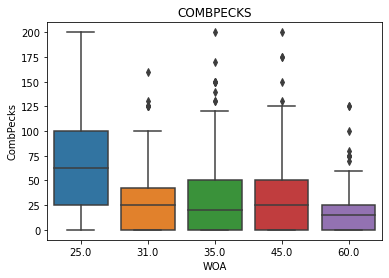

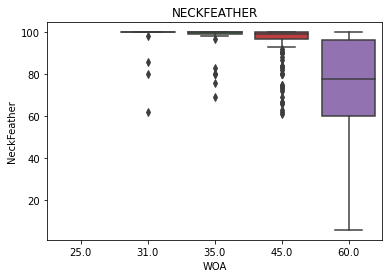

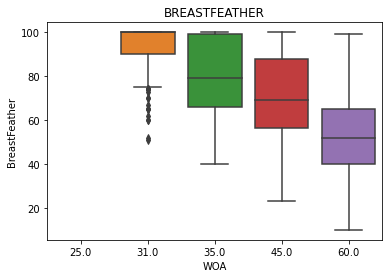

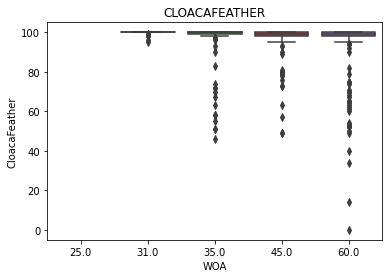

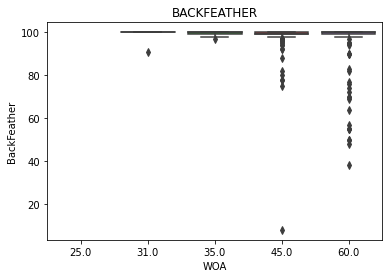

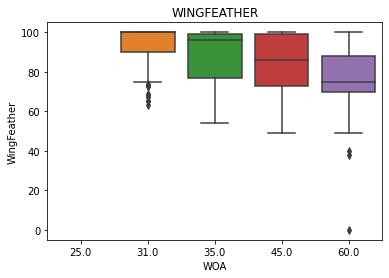

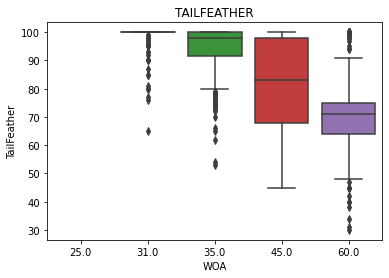

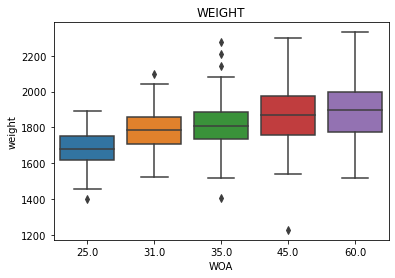

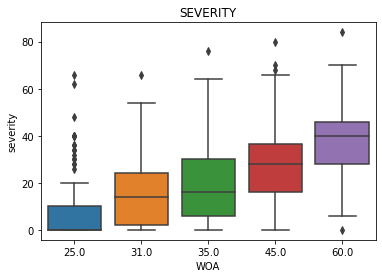

In [33]:
for v in li_HAvar:
    ax = sns.boxplot(x="WOA", y=v, data=df_HA_KBF[df_HA_KBF['IsNonFocal']==False]);
    plt.title(v.upper())
    plt.savefig(os.path.join(path_extracted_HA_visual,v+'.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()

# Non focal vs Focal - Visual

In [34]:
#### DATA
#from HA
print(df_HA_NF.shape)
display(df_HA_NF.head(2))
#from KBF
print(df_KBF_NF.shape)
display(df_KBF_NF.head(2))
#from weight
path_nf = 'G:\\VPHI\\Welfare\\2- Research Projects\\OFHE2.OriginsE2\\DataOutput\\HA\\HA5'
df_weight_NF = pd.read_csv(os.path.join(path_nf, 'non-focalbirds.csv'), sep=';') 
df_weight_NF['PenID'] = df_weight_NF['PenID'].map(lambda x: 'pen'+str(int(x)))
print(df_weight_NF.shape)
df_weight_NF.head(2)

(47, 40)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,PenMatching,IsNonFocal,Injuries,Pododermatitis,Pododermatitis_atleastonehigher100,Bumblefoot,HasBumblefoot,Toes_inflammed,GeneralToe,Feathers
2,C,NaN,pen8,1grey,NF,25.0,0,0.0,0.0,0.0,...,A,True,0.0,0.0,0,0.0,False,False,False,83.000000
3,M,NaN,pen8,16grey,NF,25.0,0,0.0,0.0,0.0,...,A,True,0.0,0.0,0,0.0,False,False,False,48.333333


(48, 15)


,initial_path_img,actual_path_img,imageID,HAID,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Unnamed: 9,Info,PenID,FocalLegringName,backpack,IsNonFocal
539,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,4.0,HA5,108.0,24,0.0,68grey8,NaN,NaN,"[, 68, grey, 8, ]",pen8,68grey,,True
544,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,9.0,HA5,247.0,34,0.0,10orange3,NaN,NaN,"[, 10, orange, 3, ]",pen3,10orange,,True


(48, 3)


,PenID,FocalLegringName,weight
0,pen3,68orange,"1746,1"
1,pen3,60orange,1752


In [35]:
### Merge data into one NF table
print(df_HA_NF.shape, df_KBF_NF.shape)
df_NF = pd.merge(df_HA_NF, df_KBF_NF, on=['FocalLegringName','PenID'], how='inner')
print(df_NF.shape)
##df_NF[(df_NF['severity'].isnull())|(df_NF['RFPododermatitis'].isnull())] #--> some birds were missed when we use how='outer'
#lets just keep birds for which we have data on all health indicator
df_NF = pd.merge(df_NF, df_weight_NF, on=['FocalLegringName','PenID'], how='inner')
print(df_NF.shape)
df_NF = df_NF.drop(['backpack','Unnamed: 9','uncertainty (0:certain:1 random)','BirdType',
                   'Commentaires','SomeHenID'], axis=1)
#save
df_NF.to_csv(os.path.join(path_extracted_data,'df_NonFocal_allHA_datda.csv'), index=False, sep=';')
df_NF.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(47, 40) (48, 15)
(45, 53)
(45, 54)


,Person_toe,Time,PenID,FocalLegringName,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,LFPododermatitis,...,actual_path_img,imageID,HAID_y,random_order1,severity,has_gap,BirdID,Info,IsNonFocal_y,weight
0,C,NaN,pen8,1grey,25.0,0,0.0,0.0,0.0,0.0,...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,123.0,HA5,128.0,12,0.0,1grey8,"[, 1, grey, 8, ]",True,"1660,1"
1,M,NaN,pen8,16grey,25.0,0,0.0,0.0,0.0,0.0,...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,124.0,HA5,85.0,52,0.0,16grey8,"[, 16, grey, 8, ]",True,"1653,7"
2,M,NaN,pen8,22grey,0.0,0,0.0,0.0,0.0,0.0,...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,371.0,HA5,68.0,26,0.0,22grey8,"[, 22, grey, 8, ]",True,"2021,1"


In [36]:
#concat with the cleaned focal table of HA5 (i.e. same date as non focal) and visualise the difference
df_NF['IsNonFocal'] = 1
df_HA_KBF['IsNonFocal'] = 0
df_NFANF = pd.concat([df_HA_KBF[df_HA_KBF['HAID']=='HA5'], df_NF])
df_NFANF['IsNonFocal']
print(df_NFANF.shape)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(203, 62)


In [37]:
df_NFANF['IsNonFocal'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    158
1     45
Name: IsNonFocal, dtype: int64

In [38]:
#number of animals per pen per group (focal ; non-focal)
df_NFANF.groupby(['PenID','IsNonFocal'])['FocalLegringName'].count().reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PenID,IsNonFocal,FocalLegringName
0,pen10,0,20
1,pen10,1,6
2,pen11,0,20
3,pen11,1,6
4,pen12,0,20
5,pen12,1,5
6,pen3,0,19
7,pen3,1,5
8,pen4,0,20
9,pen4,1,5


In [39]:
print(list(df_NF.columns))

['Person_toe', 'Time', 'PenID', 'FocalLegringName', 'CombPecks', 'Toes', 'RFPododermatitis', 'RFBumblefoot', 'RFinjuries', 'LFPododermatitis', 'LFBumblefoot', 'LFinjuries', 'Reliability_MC', 'PassageID_toe', 'Diarrhea', 'HAID_x', 'date', 'Claw', 'Person_feather', 'Reliability_SS', 'PassageID_feather', 'NeckFeather', 'BreastFeather', 'CloacaFeather', 'BackFeather', 'WingFeather', 'TailFeather', 'PenMatching', 'IsNonFocal_x', 'Injuries', 'Pododermatitis', 'Pododermatitis_atleastonehigher100', 'Bumblefoot', 'HasBumblefoot', 'Toes_inflammed', 'GeneralToe', 'Feathers', 'initial_path_img', 'actual_path_img', 'imageID', 'HAID_y', 'random_order1', 'severity', 'has_gap', 'BirdID', 'Info', 'IsNonFocal_y', 'weight', 'IsNonFocal']


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


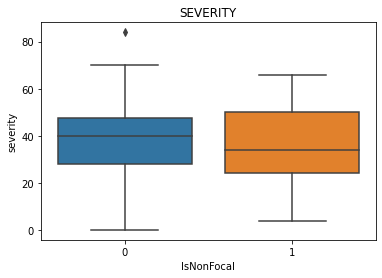

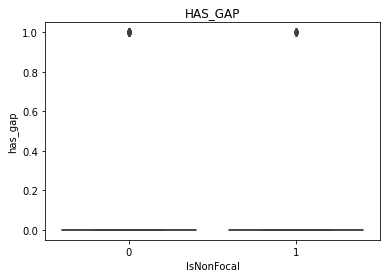

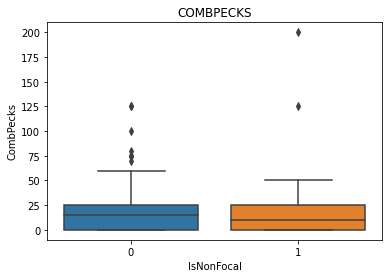

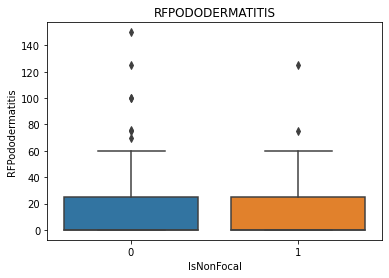

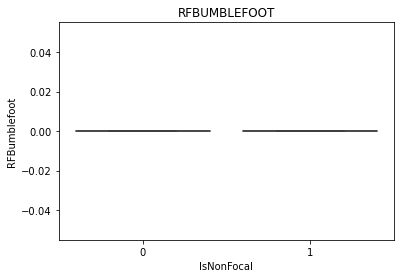

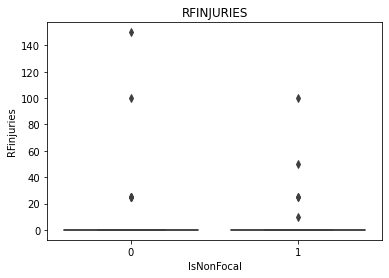

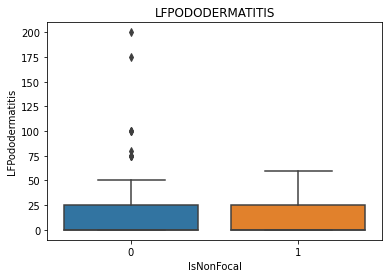

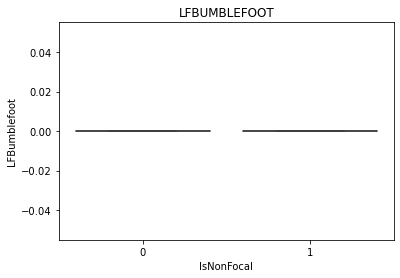

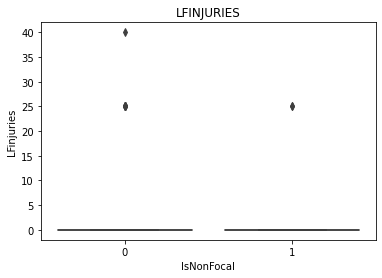

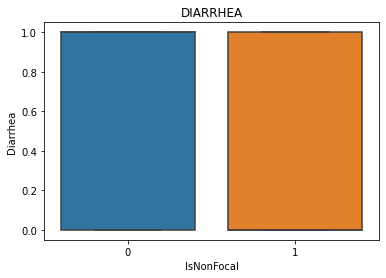

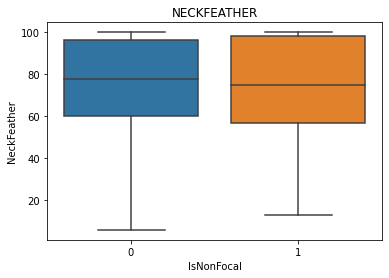

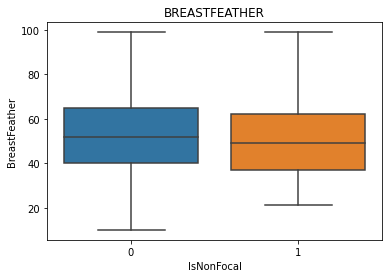

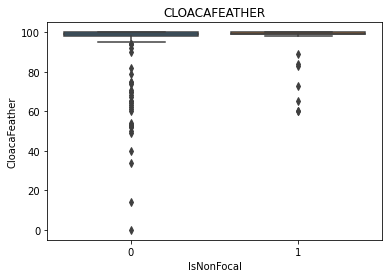

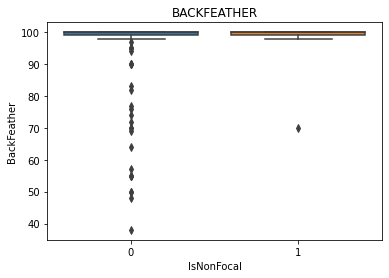

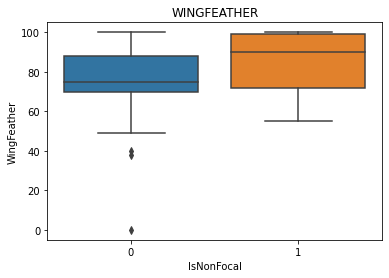

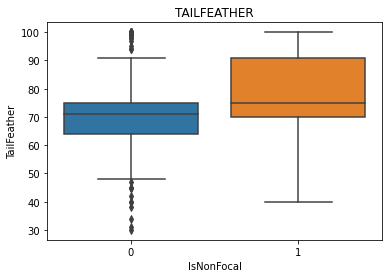

In [40]:
for v in ['severity','has_gap','CombPecks','RFPododermatitis','RFBumblefoot','RFinjuries','LFPododermatitis','LFBumblefoot',
         'LFinjuries','Diarrhea','NeckFeather', 'BreastFeather', 'CloacaFeather', 'BackFeather', 'WingFeather', 'TailFeather']:
    ax = sns.boxplot(x="IsNonFocal", y=v, data=df_NFANF);
    plt.title(v.upper())
    plt.savefig(os.path.join(path_extracted_HA_visual,v+'NFvsF.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()